In [1]:
# %load_ext autoreload
# %autoreload 2
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))

import config
from feat_util import get_train_test_from_df, get_test_from_df, get_signal, get_feat, reshape_feat
from write_audio import write_audio_for_df
from evaluate import get_results

from sklearn.utils import shuffle
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.rcParams['axes.axisbelow'] = True


C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# General use instructions
### This notebook is supplemtary to HumBugDB_main, and contains code that was run for error-checking, plotting, and other utilities.

This code is complementary to the paper: HumBugDB: a large-scale acoustic mosquito dataset. The paper describes motivations for the data, a suggestion for uses cases in [], the data collection procedure in Section [], and model benchmarking in Section []. Appendix [] gives detail on the meaning of the metadata fields that are present in the `csv` file `config.data_df`, while Appendix [] describes in more detail the models used here as baselines.


This notebook provides the interface to partition data, extract features, train a BNN model in either PyTorch or Keras and evaluate its accuracy, precision-recall, confusion matrices and uncertainty metrics. Settings are specified in `config.py` and `config_pytorch.py` or `config_keras.py` which are located in `../lib`. Functions are imported from data and feature processing code in `../lib/feat_util.py`, model training in `../lib/runTorch.py` or `../lib/runKeras.py` and evaluation in `../lib/evaluate.py`.

### Data configuration `config.py`
Specify the metadata (csv) location in `data_df`, with the location of the raw wave files in `data_dir`. The desired output for the features is set by `dir_out`. Model objects will be saved to `../models/PyTorch/`.

The feature extraction uses log-mel features with `librosa`, configurable in `config.py` with the sample rate `rate`, to which data is re-sampled on loading, a window size `win_size` which determines the size of a training window (in number of _feature_ windows), `step_size`, which determines the step size taken by the window, `NFFT`, and `n_hop`, which are parameters for the core STFT transform upon which log-mel feature extraction is based. Finally, `n_feat` determines the number of mel-frequency bands.

In `librosa`, we can calculate the value of `win_size` to achieve a user's desired `duration` for a label as follows:

`win_size` = `duration` / `frame_duration`, where `frame_duration` = `n_hop`/`rate`. Librosa uses a default `hop_length` of `NFFT/4`.
The default values in `config.py` are optimised for `rate` = 8000 with  `win_size` = 30, `NFFT` = 2048, `n_hop` = `default`,  to achieve a label duration of $30 \times 2048/(4\times 8000) = 1.92$ (s). A discussion on feature transformations is given in Appendix [] of the paper [].

### PyTorch `config_pytorch.py`
`config_pytorch.py` incldues settings to change the learning rate, `lr`, the number of maximum overrun steps for a particular training criteria `max_overrun`, the number of `epochs`, and the `batch_size`. The type of training method used can be written in `train_model.py`, which by default supports saving the best epoch models for either the training accuracy, `best_train_acc`, or validation accuracy, `best_val_acc`, if supplied to `train_model`.

### Keras `config_keras.py`
`tau = 1.0`,`lengthscale = 0.01`, are parameters used for $l2$ weight regularization supplied in lines 35-37 of `runKeras.py`. `dropout = 0.2` controls the dropout rate,`validation_split = 0.2`, is the fraction of data supplied as validation to the model callbacks in `model.fit`, line 105. `batch_size` controls the batch size, and `epochs`, set the number of epochs to train. Note the slight difference between the two packages in the way validation data is passed to the model training.


In [2]:
library = 'Keras'

if library == 'PyTorch':
    from PyTorch.runTorch import train_model, load_model, evaluate_model
elif library == 'Keras':
    from tensorflow import keras
    from Keras.runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ikiskin

## Step 2: Data partitioning for feature extraction
Feel free to adjust the training data according to any criteria available from the metadata of the labels, which are stored in `config.data_df`. The code here imports all data that is not in testing to the training set (which can then be further split into validation).
Take extra care to make sure recordings from the same experimental group, as given in Table (ref), and indicated in `df['INSERT_FIELD_HERE_ON_UPDATE']` do not appear both in train and testing, resulting in overestimate of performance on evaluation.

In [7]:
df = pd.read_csv('F:/PostdocData/HumBugServer/ServerDebug/neurips_2021_v3.csv') # Need old dataframe here to replicate stuff

# # To be kept: please do not edit the test set: these paths select test set A, test set B as described in the paper
# idx_test_A = np.logical_and(df['country'].str.contains('Tanzania'),df['location_type'].str.contains('field'))
# idx_test_B = np.logical_and(df['place'].str.contains('Oxford'),df['location_type'].str.contains('culture'))
# idx_train = np.logical_not(np.logical_or(idx_test_A, idx_test_B))
# df_test_A = df[idx_test_A]
# df_test_B = df[idx_test_B]


# df_train = df[idx_train]

# # Modify by addition or sub-sampling of df_train here
# # df_train ... 

# # Write assertion to check that train does NOT appear in test:
# assert len(np.where(pd.concat([df_train,df_test_A,
#                                df_test_B]).duplicated())[0]) == 0, 'Train dataframe contains overlap with Test A, Test B'

# Visualising species information

In [8]:
species_complexes_gambiae = ['an gambiae', 'an gambiae sl', 'an gambiae ss']
species_gambiae = ['an arabiensis', 'an coluzzii', 'an merus']
# complex: an barbirostris

In [32]:
for species in sorted(np.unique(list(df.species))):
    df_species = df[df.species ==species]
    print(species, sum(df_species.fine_end_time - df_species.fine_start_time))

ae aegypti 1331.5577879999996
ae albopictus 41.87830000000028
an albimanus 11.601386999999605
an arabiensis 18933.56993500043
an atroparvus 2.376292000000113
an barbirostris 87.81996999999996
an coluzzii 141.28472299999996
an coustani 1140.6199999999997
an dirus 914.461701
an farauti 1.1160850000000266
an freeborni 6.275591999999577
an funestus 2.079234999999983
an funestus sl 1542.0599999999993
an funestus ss 7414.240000000002
an gambiae 92.17672200000001
an gambiae sl 406.7400000000002
an gambiae ss 2474.2314880000026
an harrisoni 980.3857019999998
an leesoni 43.46000000000001
an maculatus 830.4169746462595
an maculipalpis 2012.9799999999996
an merus 1.4135249999999253
an minimus 62.963628000000085
an pharoensis 56.260000000000005
an quadriannulatus 15.88077799999985
an rivulorum 5.119999999999997
an sinensis 0.9540519999996775
an squamosus 2091.799999999999
an stephensi 69.85354499999966
an ziemanni 110.02000000000004
coquillettidia sp 25.6
culex pipiens complex 8157.76
culex quinqu

In [28]:
sorted(np.unique(list(df.species)))

['ae aegypti',
 'ae albopictus',
 'an albimanus',
 'an arabiensis',
 'an atroparvus',
 'an barbirostris',
 'an coluzzii',
 'an coustani',
 'an dirus',
 'an farauti',
 'an freeborni',
 'an funestus',
 'an funestus sl',
 'an funestus ss',
 'an gambiae',
 'an gambiae sl',
 'an gambiae ss',
 'an harrisoni',
 'an leesoni',
 'an maculatus',
 'an maculipalpis',
 'an merus',
 'an minimus',
 'an pharoensis',
 'an quadriannulatus',
 'an rivulorum',
 'an sinensis',
 'an squamosus',
 'an stephensi',
 'an ziemanni',
 'coquillettidia sp',
 'culex pipiens complex',
 'culex quinquefasciatus',
 'culex tarsalis',
 'culex tigripes',
 'ma africanus',
 'ma uniformis',
 'nan',
 'toxorhynchites brevipalpis']

Kenya
{'an gambiae ss': 2474.2314880000026}


1
CDC
{'ae aegypti': 9.117788000000118, 'ae albopictus': 41.87830000000028, 'an albimanus': 11.601386999999605, 'an arabiensis': 0.14993500000002769, 'an atroparvus': 2.376292000000113, 'an coluzzii': 1.2739540000000318, 'an dirus': 4.665802000000099, 'an farauti': 1.1160850000000266, 'an freeborni': 6.275591999999577, 'an funestus': 2.079234999999983, 'an gambiae': 3.985686000000051, 'an merus': 1.4135249999999253, 'an minimus': 1.4392340000000914, 'an quadriannulatus': 15.88077799999985, 'an sinensis': 0.9540519999996775, 'an stephensi': 6.732073999999905, 'culex q.': 7.252971000000258, 'culex tarsalis': 10.500829000000124}


18
Oxford (cage)
{'culex q.': 898.183}


1
Oxford (cup)
{'culex q.': 6573.07422777325}


1
LSTMH
{'an coluzzii': 140.01076899999993, 'an gambiae': 88.19103599999997, 'an stephensi': 63.12147099999976, 'toxorhynchites brevipalpis': 84.62701600000003}


4
Thailand
{'an barbirostris': 87.81996999999996, 'an dirus': 909.

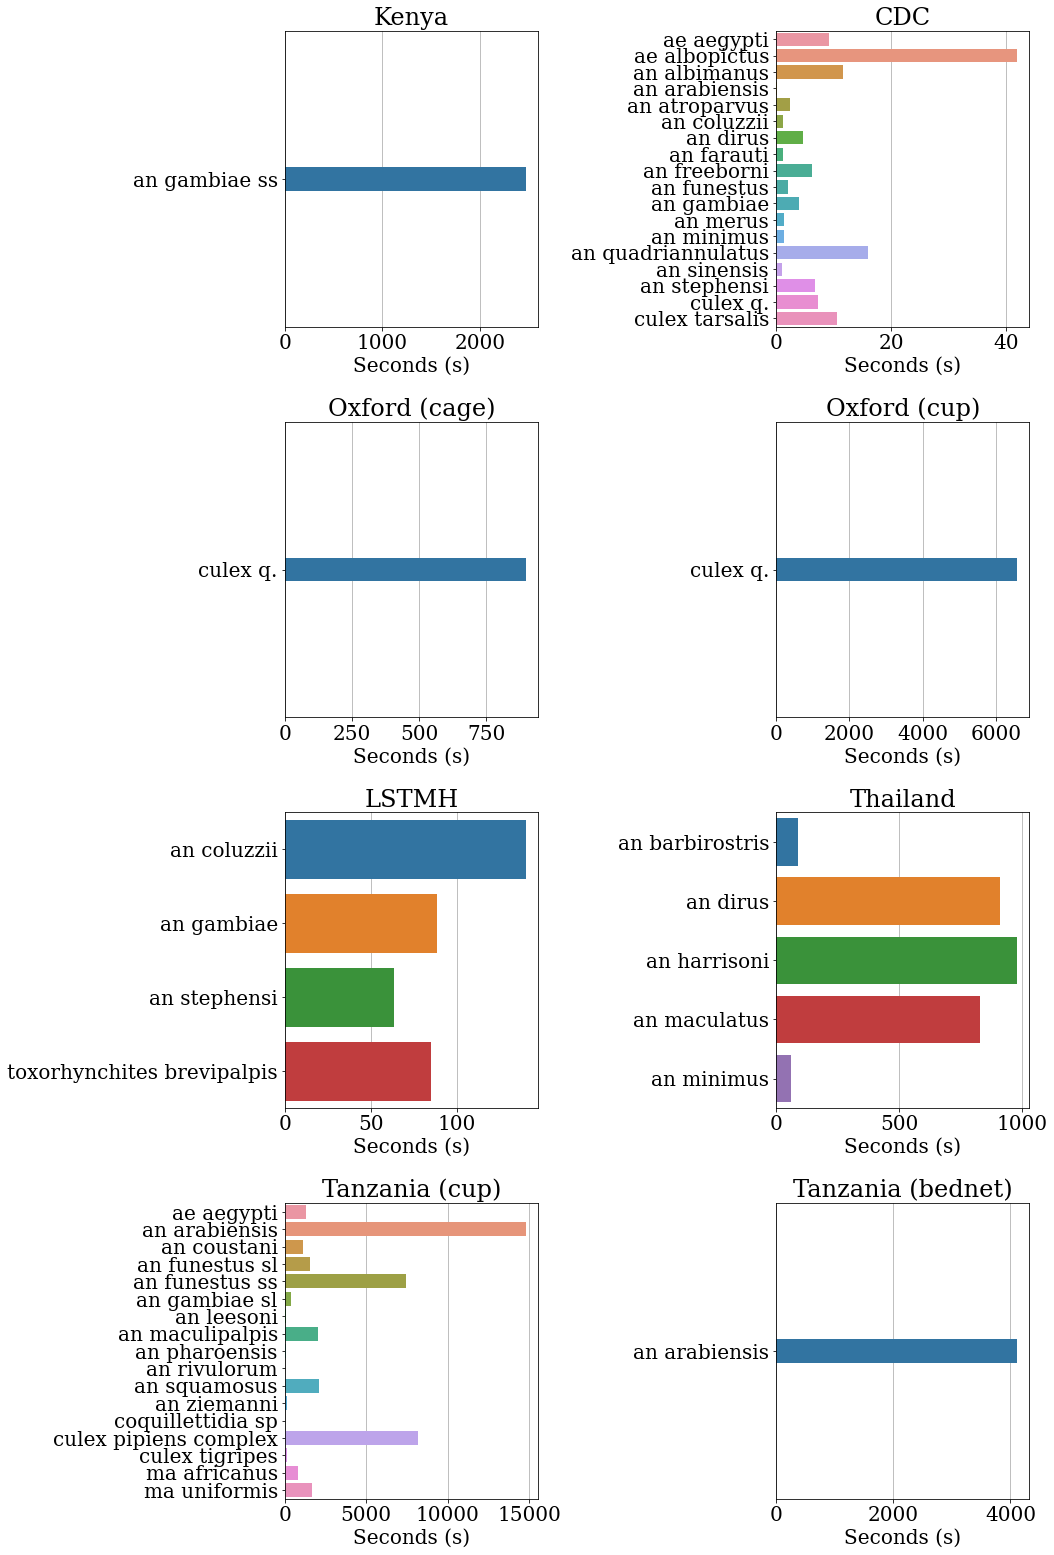

In [14]:
# Fix for compatibility with new metadata!

paths_list = ['Kenya', 'CDC','Culex/sounds/00', 'cleaned','LSTMH','Thai','IHITanzania','SemiFieldTanzania']
title_list = ['Kenya', 'CDC', 'Oxford (cage)', 'Oxford (cup)','LSTMH', 'Thailand', 'Tanzania (cup)', 'Tanzania (bednet)']

fig, axs = plt.subplots(4, 2, figsize=(15,22))
# sns.set_style("ticks")
# sns.despine(left=True, right=True)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

idx = 0
for title, path in zip(title_list,paths_list):
    df_plot = df[df['path'].str.contains(path)].replace('culex quinquefasciatus', 'culex q.')
    
    species_length = {}
    for species in sorted(pd.unique(df_plot.species.dropna())):
        species_length[species] = sum(df_plot[df_plot.species == species].fine_end_time - df_plot[df_plot.species == species].fine_start_time )
    print(title)
    print(species_length)
    print('\n')

    axs.flatten()[idx].grid()
    sns.barplot(ax = axs.flatten()[idx], y=list(species_length.keys()), x=list(species_length.values()))
    n_bars = len(list(species_length.values()))
    print(n_bars)
    if n_bars ==1:
        axs.flatten()[idx].set_ylim([-5,5])
    axs.flatten()[idx].set_title(title)
    
    axs.flatten()[idx].set_xlabel('Seconds (s)')
    idx += 1
plt.tight_layout()
# plt.savefig('D:/Postdoc/Reports/NeurIPS2021/Species.pdf')


# Verifying integrity of data

In [ ]:
# Load test data:
X_test_A, y_test_A, X_test_B, y_test_B = get_test_from_df(df_test_A, df_test_B, debug=True)

# Perform split for withholding data from test B for train and testing
train_idx_1 = np.where(y_test_B)[0][:200]
test_idx_1 = np.where(y_test_B)[0][200:]
test_idx_0 = np.where(y_test_B==0)[0][200:]
train_idx_0 = np.arange(0,200)
train_idx = np.hstack([train_idx_0, train_idx_1])
test_idx = np.hstack([test_idx_0, test_idx_1])

In [4]:
model=train_model(X_test_B[train_idx], y_test_B[train_idx])

Loading training features found at: F:/PostdocData/HumBugServer/feat_out/log_mel_feat_train_128_win_30_step_5.pickle
Loading test features found at: F:/PostdocData/HumBugServer/feat_out/log_mel_feat_test_128_win_30_step_30.pickle


## Step 4: Model evaluation

In [13]:
# PyTorch
model_name = 'model_e1_2021_06_06_15_19_18.pth'
model = load_model('ResNet50/' + model_name)

Training on cuda:0
ResNet super init self, dropout:  0.2 0.2


Generate BNN samples. Run with n_samples = 1 for deterministic NN, n >= 10 for BNN. Calculate the predictive entropy (PE), mutual information (MI), and log probabilities. Also plot the ROC curve and confusion matrix.

Evaluating on cuda:0
0.7051903114186852
0.7044982698961938
0.7044982698961938
0.7044982698961938
0.7051903114186852
0.7044982698961938
0.7038062283737024
0.7038062283737024
0.7058823529411765
0.7044982698961938


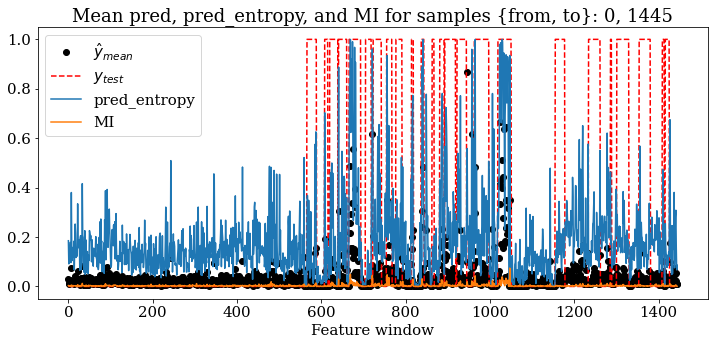

mean ROC AUC: 0.6701065414136785
std ROC AUC: 0.005723047142719453
Confusion matrix, as input by user
[[99.7143  0.2857]
 [98.5814  1.4186]]


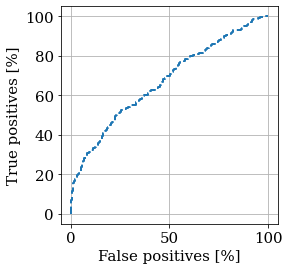

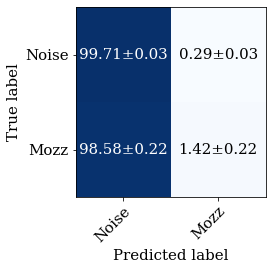

In [15]:
y_preds_all = evaluate_model(model, X_test_B, y_test_B, n_samples =10)
PE, MI, log_prob = get_results(y_preds_all,y_test_B, filename= + model_name)

# Training a model to optimise performance on bednet data

### Warning: requires access to false positives from full dataframe, not in release due to potential privacy issues:
`/data/metadata/db_10_06_21_inc_false_positives.csv`


In [3]:
from datetime import datetime
import pickle
df = pd.read_csv(config.data_df) # Read full dataframe with false positives included

df_TanzaniaSemifield = df[np.logical_and(df['country'] == 'Tanzania',df['location_type'] == 'field')]
cut_off = '2020-11-24'

df_TanzaniaSemifield_test = df_TanzaniaSemifield[pd.to_datetime(df_TanzaniaSemifield.record_datetime) 
                                                 > pd.to_datetime(cut_off)]
df_TanzaniaSemifield_train = df_TanzaniaSemifield[pd.to_datetime(df_TanzaniaSemifield.record_datetime) 
                                                  <= pd.to_datetime(cut_off)]
for i in ['false_positive', 'mosquito','background']:
    print('Train', i, sum(df_TanzaniaSemifield_train[df_TanzaniaSemifield_train.sound_type == i].length))
    print('Test', i, sum(df_TanzaniaSemifield_test[df_TanzaniaSemifield_test.sound_type == i].length))
    print('\n')

Train false_positive 4607.140000000003
Test false_positive 1182.7199999999918


Train mosquito 2140.5199999999772
Test mosquito 1977.6999999999812


Train background 2014.0
Test background 1965.72




In [ ]:
cut_off = '2020-11-24'

df_TanzaniaSemifield_test = df_TanzaniaSemifield[pd.to_datetime(df_TanzaniaSemifield.record_datetime) 
                                                 > pd.to_datetime(cut_off)]
df_TanzaniaSemifield_train = df_TanzaniaSemifield[pd.to_datetime(df_TanzaniaSemifield.record_datetime) 
                                                  <= pd.to_datetime(cut_off)]
# Create custom features with different step sizes for features

idx_train_0 = np.logical_or(df_TanzaniaSemifield_train.sound_type=='background', df_TanzaniaSemifield_train.sound_type=='false positive')
idx_train_1 = df_TanzaniaSemifield_train.sound_type=='mosquito'
idx_test_0 = np.logical_or(df_TanzaniaSemifield_test.sound_type=='background', df_TanzaniaSemifield_test.sound_type=='false positive')
idx_test_1 = df_TanzaniaSemifield_test.sound_type=='mosquito'

df_tz_tr_1 = df_TanzaniaSemifield_train[idx_train_1]
df_tz_tr_0 = df_TanzaniaSemifield_train[idx_train_0]
df_tz_te_1 = df_TanzaniaSemifield_test[idx_test_1]
df_tz_te_0 = df_TanzaniaSemifield_test[idx_test_0]
# Select indices to use different step for each class: aim to create balanced data
X_tz_tr_1, y_tz_tr_1, _,_ = get_feat(df_tz_tr_1, config.data_dir, 8000, config.min_duration, config.n_feat)
X_tz_tr_0, y_tz_tr_0, _,_ = get_feat(df_tz_tr_0, config.data_dir, 8000, config.min_duration, config.n_feat)
X_tz_te_1, y_tz_te_1, _,_ = get_feat(df_tz_te_1, config.data_dir, 8000, config.min_duration, config.n_feat)
X_tz_te_0, y_tz_te_0, _,_ = get_feat(df_tz_te_0, config.data_dir, 8000, config.min_duration, config.n_feat)


X_tz_tr_1, y_tz_tr_1 = reshape_feat(X_tz_tr_1, y_tz_tr_1,30,3)
X_tz_tr_0, y_tz_tr_0 = reshape_feat(X_tz_tr_0,y_tz_tr_0,30,6) 
X_tz_te_1, y_tz_te_1= reshape_feat(X_tz_te_1,y_tz_te_1,30,3)
X_tz_te_0, y_tz_te_0= reshape_feat(X_tz_te_0,y_tz_te_0,30,6)

print('Number of labels for: Train 1, Train 0, Test 1, Test 0:',len(y_tz_tr_1),len(y_tz_tr_0), len(y_tz_te_1),len(y_tz_te_0))

In [4]:
# log_mel_feat_train = {'X_train':np.vstack([X_tz_tr_1, X_tz_tr_0]), 'y_train':np.hstack([y_tz_tr_1, y_tz_tr_0])}
# log_mel_feat_test = {'X_test':np.vstack([X_tz_te_1, X_tz_te_0]), 'y_test':np.hstack([y_tz_te_1, y_tz_te_0])}

pickle_name_test = 'log_mel_feat_test_'+str(config.n_feat)+'_win_'+str(config.win_size)+'_step_3_noise_step_6_signal'+'_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_train = 'log_mel_feat_train_'+str(config.n_feat)+'_win_'+str(config.win_size)+'_step_3_noise_step_6_signal'+'_norm_'+str(config.norm_per_sample)+'.pickle'


# with open(os.path.join(config.dir_out, pickle_name_test), 'wb') as f:
#     pickle.dump(log_mel_feat_test, f, protocol=4)
#     print('Saved features to:', os.path.join(config.dir_out, pickle_name_test))
    
# with open(os.path.join(config.dir_out, pickle_name_train), 'wb') as f:
#     pickle.dump(log_mel_feat_train, f, protocol=4)
#     print('Saved features to:', os.path.join(config.dir_out, pickle_name_test))

In [5]:
with open(os.path.join(config.dir_out, pickle_name_train), 'rb') as input_file:
    log_mel_train = pickle.load(input_file)

# pickle_name_test = 'log_mel_feat_test_128_win_30_step_30.pickle'
with open(os.path.join(config.dir_out, pickle_name_test), 'rb') as input_file:
    log_mel_test = pickle.load(input_file)

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/features/log_mel_feat_train_128_win_30_step_3_noise_step_6_signal_norm_True.pickle'

In [ ]:
# Custom load the features we need for training

with open(os.path.join('../outputs/features/', 'log_mel_feat_train_128_win_30_step_5.pickle'), 'rb') as input_file:
    log_mel_feat = pickle.load(input_file)

X_train = np.vstack([log_mel_feat["X_train"],log_mel_train["X_train"]])
y_train = np.hstack([log_mel_feat["y_train"],log_mel_train["y_train"]])

model=train_model(X_train, y_train, log_mel_test["X_test"], log_mel_test["y_test"])

In [ ]:
y_preds_all = evaluate_model(model, log_mel_test["X_test"], log_mel_test["y_test"], n_samples = 10)
PE, MI, log_prob = get_results(y_preds_all, log_mel_test["y_test"], filename=model_name +'_Test_step6_1_step3_0_Tanzania_24-11-split')

In [ ]:
## List of model names for reference

# PyTorch: loads from ../outputs/models/pytorch/*.pth, Keras: ../outputs/models/keras/*.h5
# model_name = 'neurips_2021_humbugdb_resnet50_bnn.pth'
model_name = 'neurips_2021_humbugdb_keras_bnn.hdf5'
# model_name = 'Win_40_Stride_5_2021_06_09_23_16_46-e01-val_acc0.9249.hdf5' # wow not bad, 0.9632163181722081, UNNORM FEAT
# model_name = 'Win_40_Stride_5_2021_06_10_17_02_31-e02val_accuracy0.9859.hdf5'

# Keras new
full_path = '../outputs/models/keras/'
# model_name = 'Win_30_Stride_5_2021_06_11_10_44_54-e01val_accuracy0.9198.hdf5' # Overnight monster: All train+half of Test A
# model_name = 'Win_30_Stride_5_2021_06_10_23_59_34-e01val_accuracy0.9077.hdf5'
# Old BNN: 
# full_path = 'D:/Postdoc/MozzDetectorTestingSQL/Code/models/BNN/'
# model_name = 'Win_40_Stride_5_CNN_log-mel_128_norm_Falseheld_out_test_manual_v2_low_epoch.h5'
model = load_model(full_path + model_name)

# Utilities for debugging

In [ ]:
def detect_bug(data_df, data_dir, rate, min_duration, n_feat, flatten=True):
    ''' Returns features extracted with Librosa. A list of features, with the number of items equal to the number of input recordings'''

    bugs = []
    skipped_files = []
    for row_idx_series in data_df.iterrows():
        row = row_idx_series[1]
        label_duration = row['fine_end_time'] - row['fine_start_time']
        if label_duration > min_duration:
            _, file_format = os.path.splitext(row['path'])
            filename = os.path.join(data_dir, str(row['id']) + file_format)
            length = librosa.get_duration(filename = filename)
            if not math.isclose(length,label_duration, rel_tol=0.01):
                print("File: %s label duration (%.4f) does not match audio length (%.4f)" % (row['path'], label_duration, length))
                bugs.append([row['path'], label_duration, length])
            

        else:
            skipped_files.append([row['id'], row['path'], label_duration])
    return bugs, skipped_files

In [ ]:
import matplotlib.pyplot as plt
# plot_mel_spectrum_db(X_test_norm_B, y_test_B, 40, norm_sample=False)

def normalise_per_sample(X):
    '''Use sample normalisation per audio clip: equivalent to histogram normalisation per image. Expects TF dimensions'''
    
    X_norm = np.copy(X)
    for idx, sample in enumerate(X):
        X_norm[idx] = (sample-np.mean(sample))/np.std(sample)
    
    return X_norm

def plot_mel_spectrum_db(X, y, idx, norm_sample=True):
    ''' X in tensorflow dim, y categorical. 0 <= idx <= len(y) points to sample. '''
    if norm_sample:
        X = (X[idx] - np.mean(X[idx]))/np.std(X[idx])
    else:
        X = X[idx]

    plt.imshow(X.squeeze().T, aspect='auto', origin='lower')
    plt.title(('Label:', y[idx]))
    plt.colorbar()

# Unused code for extra species classification on recordings

In [ ]:
import feat_vggish
def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, y_item = feat_vggish.reshape_feat([recording], [y_test[idx]])
        preds_list = evaluate_model(model, X_item, y_item, BNN_samples)
        preds_values = np.mean(preds_list,axis=0)
        print(preds_values)
        print('shape', np.shape(preds_values))
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean

def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, _ = feat_util.reshape_feat([recording], [y_test[idx]], config.win_size, config.step_size)
        for i in range(BNN_samples):
            preds_values = model.predict(X_item)
            preds_list.append(preds_values)
        preds_values = np.mean(preds_list,axis=0)
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean


preds_aggregated_by_mean, y_aggregated_prediction_by_mean = evaluate_aggregate_predictions(X_test, y_test, model, 2)

from sklearn.metrics import accuracy_score

from torch.utils.data import TensorDataset, DataLoader
import torch
def evaluate_model(model, X_test, y_test, n_samples):
    # Determine number of classes: warning potential issue if predicted classes dont match
    # number of classes in y_test
    n_classes = config_pytorch.n_classes 
                    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Evaluating on {device}')

    x_test = torch.tensor(X_test).float()
    if model.n_channels == 3:
        x_test = x_test.repeat(1,3,1,1)

    y_test = torch.tensor(y_test).float()
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    y_preds_all = np.zeros([n_samples, len(y_test), n_classes])
    model.eval() # Important to not leak info from batch norm layers and cause other issues

    for n in range(n_samples):
        all_y_pred = []
        all_y = []
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_pred = model(x).squeeze()
            all_y.append(y.cpu().detach())

            all_y_pred.append(y_pred.cpu().detach())

            del x
            del y
            del y_pred

        all_y_pred = torch.cat(all_y_pred)
        all_y = torch.cat(all_y)

        y_preds_all[n] = np.array(all_y_pred)
       
        test_acc = accuracy_score(all_y.numpy(), np.argmax(all_y_pred.numpy(), axis=1))
        print(test_acc)
    return y_preds_all